In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sdm.config import get_db_connection
from sdm.crud_embeddings import get_all_embeddings
from sdm.utils import get_pi_ba_dataframe, get_ja_aa_pa_sa_bot_dataframe

In [2]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

In [4]:
with get_db_connection(db_type="postgres") as db:
    df = get_all_embeddings(db)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112055 entries, 0 to 112054
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         112055 non-null  int64 
 1   text       112055 non-null  object
 2   doc_type   112055 non-null  object
 3   doc_id     112055 non-null  object
 4   embedding  112055 non-null  object
dtypes: int64(1), object(4)
memory usage: 4.3+ MB


In [4]:
df.head()

,id,text,doc_type,doc_id,embedding
0,52637,#COP21 Video: #climate &amp; #renewableenergy ...,tweet,675825185124179968,"[-0.069058955, 0.1253654, -0.008005843, -0.056..."
1,15822,@JWSoder Is that like #US trying to stop #Mass...,tweet,675825158154641408,"[-0.026099898, 0.0872428, -0.008782464, -0.118..."
2,79775,RT @AGarlandPhoto: #Seattle marches in solidar...,tweet,675824907645665280,"[-0.17288554, 0.060270026, -0.008595197, -0.04..."
3,15824,.@JWSoder We should use #science-based policy ...,tweet,675824675868434432,"[-0.027622614, 0.34542358, -0.010848413, -0.08..."
4,40126,#Ambassades @FranciaPanama: RT @MikeBloomberg:...,tweet,675824536659496960,"[-0.15963376, 0.25710335, -0.0064884974, -0.05..."


In [4]:
print(df["doc_type"].value_counts())

doc_type
tweet         106735
comment         5000
submission       320
Name: count, dtype: int64


In [5]:
tweet_df = df[df["doc_type"] == "tweet"]

In [6]:
com_sub_df = df[df["doc_type"] != "tweet"]
print(com_sub_df.info())
com_sub_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5320 entries, 106735 to 112054
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         5320 non-null   int64 
 1   text       5320 non-null   object
 2   doc_type   5320 non-null   object
 3   doc_id     5320 non-null   object
 4   embedding  5320 non-null   object
dtypes: int64(1), object(4)
memory usage: 249.4+ KB
None


,id,text,doc_type,doc_id,embedding
106735,1,<1000 premises since the rollout began shows i...,comment,cxitaut,"[0.08825734, 0.21635935, -0.0017377635, -0.032..."
106736,2,Polar bears are scientists more than anything ...,comment,cxihb2y,"[0.04676613, 0.1897849, -0.0059557245, 0.01747..."
106737,3,Ha. Je l'attendais celui-là...\n\n> Les glacie...,comment,cxbw5l1,"[0.12459618, 0.1724063, -0.011436634, 0.114541..."
106738,4,Thanks. I get so hungry after working out in t...,comment,cxi5862,"[-0.0996766, 0.016045595, -0.0054547777, 0.202..."
106739,5,A march its still planned in Paris by a collec...,comment,cx8ej76,"[-0.038831882, 0.37239313, -0.008076593, 0.051..."


In [7]:
with get_db_connection(db_type="postgres") as db:
    pi_ba_df = get_pi_ba_dataframe(db)
pi_ba_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33692 entries, 0 to 33691
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   account_id    33692 non-null  object
 1   doc_id        33692 non-null  object
 2   account_type  33692 non-null  object
 3   lang          33692 non-null  object
 4   stance        33692 non-null  object
dtypes: object(5)
memory usage: 1.3+ MB


In [38]:
pi_df = pi_ba_df[pi_ba_df["account_type"] == "Private individuals"]
print(pi_df.shape)
ba_df = pi_ba_df[pi_ba_df["account_type"] == "Business actors"]
print(ba_df.shape)

(23611, 5)
(10081, 5)


In [39]:
pi_df = pd.merge(pi_df, tweet_df, how="left", on="doc_id")
pi_df = pi_df[pi_df["embedding"].notnull()]
print(pi_df.info())
pi_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 21945 entries, 0 to 23610
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   account_id    21945 non-null  object 
 1   doc_id        21945 non-null  object 
 2   account_type  21945 non-null  object 
 3   lang          21945 non-null  object 
 4   stance        21945 non-null  object 
 5   id            21945 non-null  float64
 6   text          21945 non-null  object 
 7   doc_type      21945 non-null  object 
 8   embedding     21945 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.7+ MB
None


,account_id,doc_id,account_type,lang,stance,id,text,doc_type,embedding
0,2374469136,675825881600819200,Private individuals,fr,Unclear,15586.0,@JdeQuebec Vraiment le pot fait de mauvais eff...,tweet,"[-0.05918192, 0.22358717, -0.016498389, -0.029..."
1,74508903,675821381943238657,Private individuals,fr,Unclear,12552.0,"[Direct #COP21 ] @LaurentFabius ""la séance est...",tweet,"[-0.08324683, 0.14276661, -0.013592841, -0.009..."
4,74508903,675820988400066560,Private individuals,fr,Unclear,12549.0,[Direct #COP21 ] @LaurentFabius annonce la clô...,tweet,"[-0.15941124, -0.012673036, -0.009087384, 0.04..."
8,21150492,675820252685598720,Private individuals,en,Against,13489.0,"Finally, #COP21 ends... climate comedy show no...",tweet,"[-0.033735186, 0.2543257, -0.00588581, -0.0351..."
9,1433456161,675820040420126720,Private individuals,en,For,23947.0,RT @Ela0310: CORPORATE #KillerPalm SUSTAINABLE...,tweet,"[-0.03341059, 0.2015346, -0.011685144, 0.02554..."


In [40]:
pi_cluster_df = pi_df[["id", "text", "doc_type", "doc_id", "embedding"]]
pi_cluster_df["id"] = pi_cluster_df["id"].astype("int64")
pi_cluster_df.head()

C:\Users\anand\AppData\Local\Temp\ipykernel_26672\690050131.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pi_cluster_df["id"] = pi_cluster_df["id"].astype("int64")


,id,text,doc_type,doc_id,embedding
0,15586,@JdeQuebec Vraiment le pot fait de mauvais eff...,tweet,675825881600819200,"[-0.05918192, 0.22358717, -0.016498389, -0.029..."
1,12552,"[Direct #COP21 ] @LaurentFabius ""la séance est...",tweet,675821381943238657,"[-0.08324683, 0.14276661, -0.013592841, -0.009..."
4,12549,[Direct #COP21 ] @LaurentFabius annonce la clô...,tweet,675820988400066560,"[-0.15941124, -0.012673036, -0.009087384, 0.04..."
8,13489,"Finally, #COP21 ends... climate comedy show no...",tweet,675820252685598720,"[-0.033735186, 0.2543257, -0.00588581, -0.0351..."
9,23947,RT @Ela0310: CORPORATE #KillerPalm SUSTAINABLE...,tweet,675820040420126720,"[-0.03341059, 0.2015346, -0.011685144, 0.02554..."


In [41]:
pi_cluster_df = pd.concat([pi_cluster_df, com_sub_df], ignore_index=True)
print(pi_cluster_df.info())
pi_cluster_df[pi_cluster_df["doc_type"] == "comment"].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27265 entries, 0 to 27264
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         27265 non-null  int64 
 1   text       27265 non-null  object
 2   doc_type   27265 non-null  object
 3   doc_id     27265 non-null  object
 4   embedding  27265 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.0+ MB
None


,id,text,doc_type,doc_id,embedding
21945,1,<1000 premises since the rollout began shows i...,comment,cxitaut,"[0.08825734, 0.21635935, -0.0017377635, -0.032..."
21946,2,Polar bears are scientists more than anything ...,comment,cxihb2y,"[0.04676613, 0.1897849, -0.0059557245, 0.01747..."
21947,3,Ha. Je l'attendais celui-là...\n\n> Les glacie...,comment,cxbw5l1,"[0.12459618, 0.1724063, -0.011436634, 0.114541..."
21948,4,Thanks. I get so hungry after working out in t...,comment,cxi5862,"[-0.0996766, 0.016045595, -0.0054547777, 0.202..."
21949,5,A march its still planned in Paris by a collec...,comment,cx8ej76,"[-0.038831882, 0.37239313, -0.008076593, 0.051..."


In [42]:
pi_embeddings = np.stack(pi_cluster_df["embedding"].to_numpy())

scaler = StandardScaler()
pi_embeddings_scaled = scaler.fit_transform(pi_embeddings)

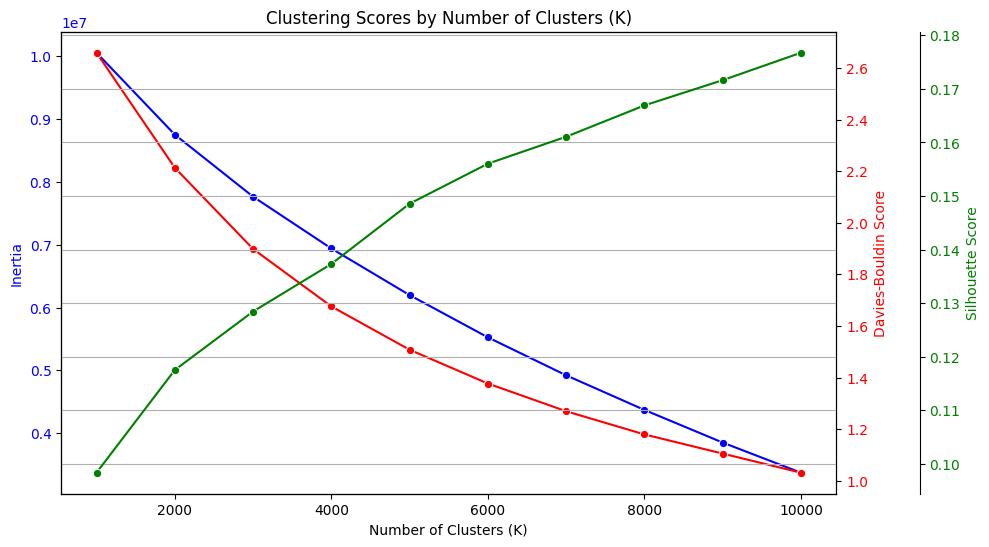

In [17]:
k_values = range(1000, 10001, 1000)

# Store the inertia for each k
scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pi_embeddings_scaled)
    label = kmeans.labels_
    db_score = davies_bouldin_score(pi_embeddings_scaled, label)
    sil_score = silhouette_score(pi_embeddings_scaled, label)
    scores.append({
        "K": k,
        "inertia": kmeans.inertia_,
        "db": db_score,
        "silh": sil_score,
        })

# Plot the scores
df_scores = pd.DataFrame(scores)
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot inertia
sns.lineplot(data=df_scores, x="K", y="inertia", ax=ax1, color="blue", marker="o")
ax1.set_ylabel("Inertia", color="blue")
ax1.set_xlabel("Number of Clusters (K)")
ax1.tick_params(axis='y', labelcolor="blue")

# Create a second y-axis for the Davies-Bouldin score
ax2 = ax1.twinx()
sns.lineplot(data=df_scores, x="K", y="db", ax=ax2, color="red", marker="o")
ax2.set_ylabel("Davies-Bouldin Score", color="red")
ax2.tick_params(axis='y', labelcolor="red")

# Create a third y-axis for the Silhouette score
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Move the third axis to avoid overlap
sns.lineplot(data=df_scores, x="K", y="silh", ax=ax3, color="green", marker="o")
ax3.set_ylabel("Silhouette Score", color="green")
ax3.tick_params(axis='y', labelcolor="green")

plt.title('Clustering Scores by Number of Clusters (K)')
plt.grid(True)
plt.show()

In [43]:
n_clusters = 10000
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
pi_cluster_df["cluster"] = kmeans.fit_predict(pi_embeddings_scaled)

print("Clustered data:")
pi_cluster_df.head()

Clustered data:


,id,text,doc_type,doc_id,embedding,cluster
0,15586,@JdeQuebec Vraiment le pot fait de mauvais eff...,tweet,675825881600819200,"[-0.05918192, 0.22358717, -0.016498389, -0.029...",3739
1,12552,"[Direct #COP21 ] @LaurentFabius ""la séance est...",tweet,675821381943238657,"[-0.08324683, 0.14276661, -0.013592841, -0.009...",7992
2,12549,[Direct #COP21 ] @LaurentFabius annonce la clô...,tweet,675820988400066560,"[-0.15941124, -0.012673036, -0.009087384, 0.04...",1445
3,13489,"Finally, #COP21 ends... climate comedy show no...",tweet,675820252685598720,"[-0.033735186, 0.2543257, -0.00588581, -0.0351...",6597
4,23947,RT @Ela0310: CORPORATE #KillerPalm SUSTAINABLE...,tweet,675820040420126720,"[-0.03341059, 0.2015346, -0.011685144, 0.02554...",870


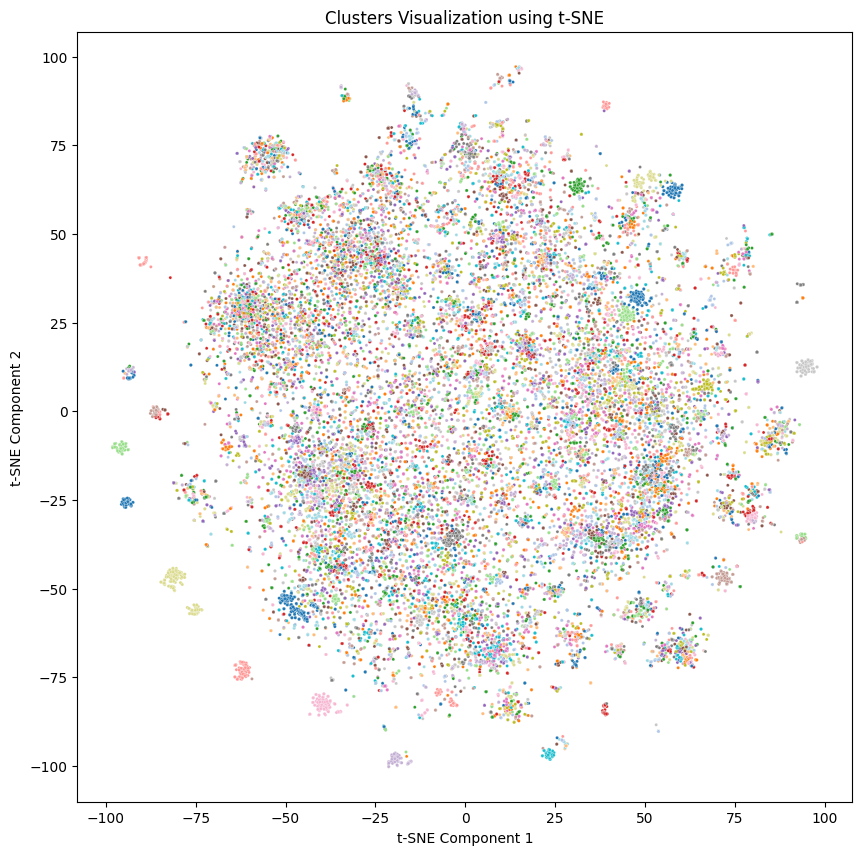

In [45]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(pi_embeddings_scaled)

pi_cluster_df['TSNE1'] = embeddings_2d[:, 0]
pi_cluster_df['TSNE2'] = embeddings_2d[:, 1]

# Plot clusters
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x='TSNE1', y='TSNE2', hue='cluster', palette='tab20', data=pi_cluster_df, s=5, legend=False)

plt.title('Clusters Visualization using t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [94]:
value_count = pi_cluster_df["cluster"].value_counts()
filtered_values = value_count[(value_count > 30) & (value_count < 40)].index
filtered_df = pi_cluster_df[pi_cluster_df["cluster"].isin(filtered_values)]
print(filtered_df["cluster"].value_counts())

cluster
949     38
3498    36
2249    36
2407    36
6       35
9453    34
2       34
334     34
5897    32
2397    32
389     32
4305    31
521     31
Name: count, dtype: int64


In [65]:
pi_cluster_df[pi_cluster_df["cluster"] == 186].head()

,id,text,doc_type,doc_id,embedding,cluster,TSNE1,TSNE2
7019,10255,"#COP21: Le bassin du Congo, le 2e poumon de la...",tweet,674554344809717760,"[0.030489288, -0.015046924, -0.014883637, -0.0...",186,38.515106,-83.031570
7020,10254,"#COP21: Le bassin du Congo, le 2e poumon de la...",tweet,674554317475471360,"[0.02878131, -0.018345848, -0.015017509, 0.001...",186,38.539974,-83.087166
7100,10253,"#COP21: Le bassin du Congo, le 2e poumon de la...",tweet,674554261640839168,"[0.028211206, -0.018273005, -0.014891028, 0.00...",186,38.571671,-83.006004
7101,10252,"#COP21: Le bassin du Congo, le 2e poumon de la...",tweet,674554232033316864,"[0.028897256, -0.027081817, -0.01504755, 0.002...",186,38.414223,-83.135674
7102,10256,"#COP21: Le bassin du Congo, le 2e poumon de la...",tweet,674554197514149888,"[0.028340802, -0.019353718, -0.014947772, 0.00...",186,38.553909,-82.978180


In [108]:
cluster4317 = pi_cluster_df[pi_cluster_df["cluster"] == 521]
print(cluster4317["doc_type"].value_counts())

doc_type
tweet    31
Name: count, dtype: int64


In [97]:
cluster4317.tail()

,id,text,doc_type,doc_id,embedding,cluster,TSNE1,TSNE2
20661,14786,ID4D: ACF_France COP21 PascalPeggy Bertrand_No...,tweet,671314103172997120,"[-0.11241279, 0.27955276, -0.010622876, 0.0010...",3498,10.290714,-60.650967
21081,23142,"RT @COP21: .@fhollande ""le 12 décembre doit êt...",tweet,671278579657895937,"[-0.08708131, 0.22233751, -0.008046652, -0.027...",3498,8.472137,-67.364166
21234,36589,"World leaders, the fate of Paris Agreements it...",tweet,671277413138079744,"[-0.10387124, 0.21356678, -0.0105926655, -0.06...",3498,9.410658,-63.739510
21569,10672,#COP21 : les points clés du projet d’Accord de...,tweet,671224165790257152,"[-0.11281243, 0.13063037, -0.01320003, -0.0711...",3498,9.249955,-65.157883
26071,4127,So the Us constitution requires all treaties b...,comment,io5qm2a,"[-0.04987279, 0.21025383, -0.0033498546, -0.05...",3498,7.073199,-66.695343


Cluster 295, 3498 has 1 comment with tweets

Business Actors

In [109]:
ba_df = pd.merge(ba_df, tweet_df, how="left", on="doc_id")
ba_df = ba_df[ba_df["embedding"].notnull()]
print(ba_df.info())
ba_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 9515 entries, 0 to 10080
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   account_id    9515 non-null   object 
 1   doc_id        9515 non-null   object 
 2   account_type  9515 non-null   object 
 3   lang          9515 non-null   object 
 4   stance        9515 non-null   object 
 5   id            9515 non-null   float64
 6   text          9515 non-null   object 
 7   doc_type      9515 non-null   object 
 8   embedding     9515 non-null   object 
dtypes: float64(1), object(8)
memory usage: 743.4+ KB
None


,account_id,doc_id,account_type,lang,stance,id,text,doc_type,embedding
0,18290719,675826279099273216,Business actors,en,For,14476.0,Highlights and shortcomings in the latest Pari...,tweet,"[-0.20108446, 0.21596618, -0.006108716, -0.025..."
1,18290719,675821277446340608,Business actors,en,For,17007.0,Less meat consumption critical to achieve glob...,tweet,"[-0.106734574, 0.3748691, -0.0034504347, -0.04..."
2,3168316102,675820911346507776,Business actors,en,Unclear,19959.0,RelaxInCanada: DenisLambert4: RT mbinzolambert...,tweet,"[-0.15346462, 0.30668378, -0.012330985, 0.0621..."
3,75562656,675814200770494464,Business actors,en,Unclear,32653.0,RT @WRIClimate: From @ClimateMorgan -This agre...,tweet,"[-0.14477748, 0.16148129, -0.00084509735, -0.0..."
4,150800182,675814043119132676,Business actors,en,Unclear,33735.0,Thank you @lisaelisabethd for delivering busin...,tweet,"[-0.087782264, 0.05106796, -0.011101956, 0.023..."


In [110]:
ba_cluster_df = ba_df[["id", "text", "doc_type", "doc_id", "embedding"]]
ba_cluster_df["id"] = ba_cluster_df["id"].astype("int64")
ba_cluster_df.head()

C:\Users\anand\AppData\Local\Temp\ipykernel_26672\427865840.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ba_cluster_df["id"] = ba_cluster_df["id"].astype("int64")


,id,text,doc_type,doc_id,embedding
0,14476,Highlights and shortcomings in the latest Pari...,tweet,675826279099273216,"[-0.20108446, 0.21596618, -0.006108716, -0.025..."
1,17007,Less meat consumption critical to achieve glob...,tweet,675821277446340608,"[-0.106734574, 0.3748691, -0.0034504347, -0.04..."
2,19959,RelaxInCanada: DenisLambert4: RT mbinzolambert...,tweet,675820911346507776,"[-0.15346462, 0.30668378, -0.012330985, 0.0621..."
3,32653,RT @WRIClimate: From @ClimateMorgan -This agre...,tweet,675814200770494464,"[-0.14477748, 0.16148129, -0.00084509735, -0.0..."
4,33735,Thank you @lisaelisabethd for delivering busin...,tweet,675814043119132676,"[-0.087782264, 0.05106796, -0.011101956, 0.023..."


In [111]:
ba_cluster_df = pd.concat([ba_cluster_df, com_sub_df], ignore_index=True)
print(ba_cluster_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         14835 non-null  int64 
 1   text       14835 non-null  object
 2   doc_type   14835 non-null  object
 3   doc_id     14835 non-null  object
 4   embedding  14835 non-null  object
dtypes: int64(1), object(4)
memory usage: 579.6+ KB
None


,id,text,doc_type,doc_id,embedding
9515,1,<1000 premises since the rollout began shows i...,comment,cxitaut,"[0.08825734, 0.21635935, -0.0017377635, -0.032..."
9516,2,Polar bears are scientists more than anything ...,comment,cxihb2y,"[0.04676613, 0.1897849, -0.0059557245, 0.01747..."
9517,3,Ha. Je l'attendais celui-là...\n\n> Les glacie...,comment,cxbw5l1,"[0.12459618, 0.1724063, -0.011436634, 0.114541..."
9518,4,Thanks. I get so hungry after working out in t...,comment,cxi5862,"[-0.0996766, 0.016045595, -0.0054547777, 0.202..."
9519,5,A march its still planned in Paris by a collec...,comment,cx8ej76,"[-0.038831882, 0.37239313, -0.008076593, 0.051..."


In [120]:
ba_embeddings = np.stack(ba_cluster_df["embedding"].to_numpy())

ba_embeddings_scaled = scaler.fit_transform(ba_embeddings)

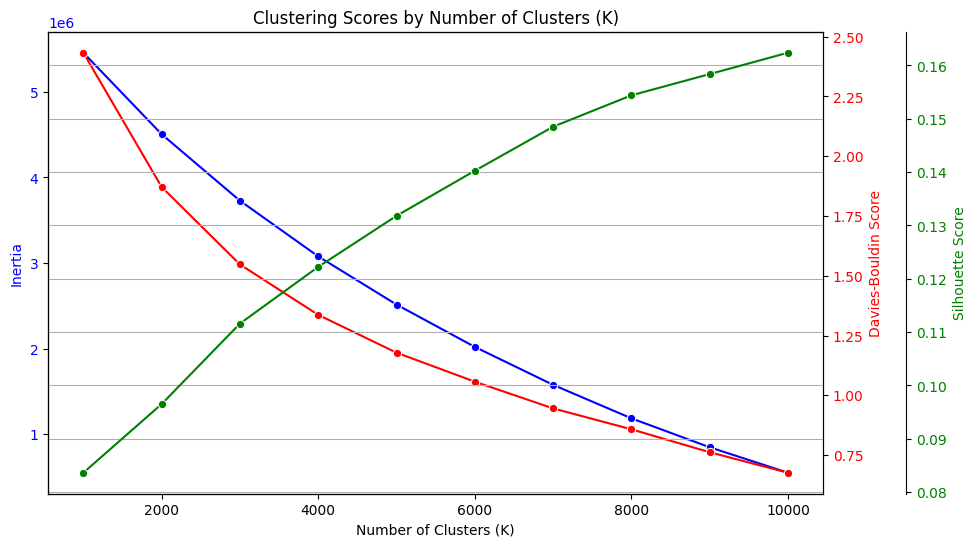

In [113]:
k_values = range(1000, 10001, 1000)

# Store the inertia for each k
scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(ba_embeddings_scaled)
    label = kmeans.labels_
    db_score = davies_bouldin_score(ba_embeddings_scaled, label)
    sil_score = silhouette_score(ba_embeddings_scaled, label)
    scores.append({
        "K": k,
        "inertia": kmeans.inertia_,
        "db": db_score,
        "silh": sil_score,
        })

# Plot the scores
df_scores = pd.DataFrame(scores)
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot inertia
sns.lineplot(data=df_scores, x="K", y="inertia", ax=ax1, color="blue", marker="o")
ax1.set_ylabel("Inertia", color="blue")
ax1.set_xlabel("Number of Clusters (K)")
ax1.tick_params(axis='y', labelcolor="blue")

# Create a second y-axis for the Davies-Bouldin score
ax2 = ax1.twinx()
sns.lineplot(data=df_scores, x="K", y="db", ax=ax2, color="red", marker="o")
ax2.set_ylabel("Davies-Bouldin Score", color="red")
ax2.tick_params(axis='y', labelcolor="red")

# Create a third y-axis for the Silhouette score
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Move the third axis to avoid overlap
sns.lineplot(data=df_scores, x="K", y="silh", ax=ax3, color="green", marker="o")
ax3.set_ylabel("Silhouette Score", color="green")
ax3.tick_params(axis='y', labelcolor="green")

plt.title('Clustering Scores by Number of Clusters (K)')
plt.grid(True)
plt.show()

In [118]:
# Removing the cases where text is NA
ba_cluster_df = ba_cluster_df[ba_cluster_df["cluster"] != 5]
ba_cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14192 entries, 0 to 14832
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         14192 non-null  int64  
 1   text       14192 non-null  object 
 2   doc_type   14192 non-null  object 
 3   doc_id     14192 non-null  object 
 4   embedding  14192 non-null  object 
 5   cluster    14192 non-null  int32  
 6   TSNE1      14192 non-null  float32
 7   TSNE2      14192 non-null  float32
dtypes: float32(2), int32(1), int64(1), object(4)
memory usage: 831.6+ KB


In [140]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
ba_cluster_df["cluster"] = kmeans.fit_predict(ba_embeddings_scaled)

print("Clustered data:")
ba_cluster_df.head()

Clustered data:


,id,text,doc_type,doc_id,embedding,cluster,TSNE1,TSNE2
0,14476,Highlights and shortcomings in the latest Pari...,tweet,675826279099273216,"[-0.20108446, 0.21596618, -0.006108716, -0.025...",1,46.551556,-27.726048
1,17007,Less meat consumption critical to achieve glob...,tweet,675821277446340608,"[-0.106734574, 0.3748691, -0.0034504347, -0.04...",7,-47.760452,58.755653
2,19959,RelaxInCanada: DenisLambert4: RT mbinzolambert...,tweet,675820911346507776,"[-0.15346462, 0.30668378, -0.012330985, 0.0621...",5,10.404369,-78.616196
3,32653,RT @WRIClimate: From @ClimateMorgan -This agre...,tweet,675814200770494464,"[-0.14477748, 0.16148129, -0.00084509735, -0.0...",1,49.805920,-28.568834
4,33735,Thank you @lisaelisabethd for delivering busin...,tweet,675814043119132676,"[-0.087782264, 0.05106796, -0.011101956, 0.023...",7,53.897770,22.016926


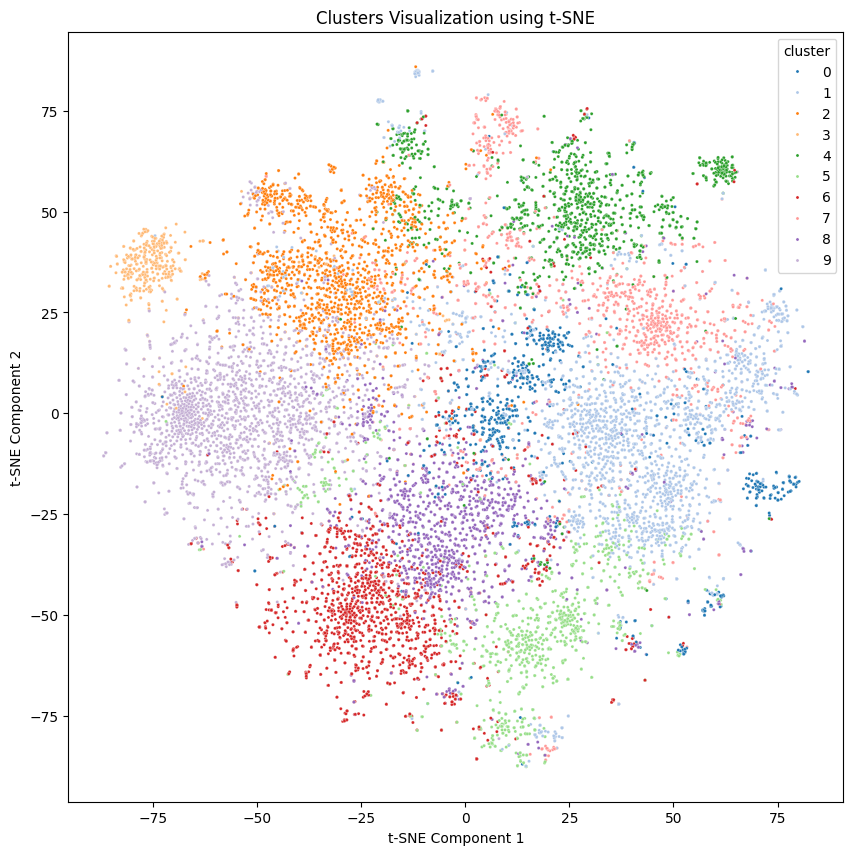

In [160]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(ba_embeddings_scaled)

ba_cluster_df['TSNE1'] = embeddings_2d[:, 0]
ba_cluster_df['TSNE2'] = embeddings_2d[:, 1]

# Plot clusters
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x='TSNE1', y='TSNE2', hue='cluster', palette='tab20', data=ba_cluster_df, s=5, legend=True)

plt.title('Clusters Visualization using t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [142]:
value_count = ba_cluster_df["cluster"].value_counts()
print(value_count)
# filtered_values = value_count[(value_count > 30) & (value_count < 40)].index
# filtered_df = ba_cluster_df[ba_cluster_df["cluster"].isin(filtered_values)]
# print(filtered_df["cluster"].value_counts())

cluster
1    2496
9    2125
6    1676
2    1551
7    1387
8    1387
4    1312
5    1066
0     825
3     367
Name: count, dtype: int64


In [158]:
cluster = ba_cluster_df[ba_cluster_df["cluster"] == 3]
print(cluster["doc_type"].value_counts())

doc_type
comment       363
tweet           3
submission      1
Name: count, dtype: int64


In [163]:
cluster.head()

,id,text,doc_type,doc_id,embedding,cluster,TSNE1,TSNE2
1608,33591,targtj: RT Haggisman57: Return of Arctic ice c...,tweet,674953940480483328,"[-0.10807845, 0.013324471, -0.0046793805, 0.04...",3,-5.351578,14.681057
2145,12777,"Drew Shindell, Chair of CCAC Scientific Adviso...",tweet,674648118324019200,"[-0.13943525, -0.1191284, -0.001200529, 0.0422...",3,-2.958821,22.117882
2233,30989,RT @UNFCCC: A very cool @Greenpeace polar bear...,tweet,674622489935396864,"[-0.042182222, 0.10577704, -0.006542966, 0.033...",3,-78.077232,30.947510
9516,2,Polar bears are scientists more than anything ...,comment,cxihb2y,"[0.04676613, 0.1897849, -0.0059557245, 0.01747...",3,-76.362923,35.663929
9518,4,Thanks. I get so hungry after working out in t...,comment,cxi5862,"[-0.0996766, 0.016045595, -0.0054547777, 0.202...",3,-70.370682,9.808492


In [8]:
pi_ba_df = pd.merge(pi_ba_df, tweet_df, how="left", on="doc_id")
pi_ba_df = pi_ba_df[pi_ba_df["embedding"].notnull()]
print(pi_ba_df.info())
pi_ba_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 31460 entries, 0 to 33691
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   account_id    31460 non-null  object 
 1   doc_id        31460 non-null  object 
 2   account_type  31460 non-null  object 
 3   lang          31460 non-null  object 
 4   stance        31460 non-null  object 
 5   id            31460 non-null  float64
 6   text          31460 non-null  object 
 7   doc_type      31460 non-null  object 
 8   embedding     31460 non-null  object 
dtypes: float64(1), object(8)
memory usage: 2.4+ MB
None


,account_id,doc_id,account_type,lang,stance,id,text,doc_type,embedding
0,2374469136,675822700045074432,Private individuals,fr,Unclear,33412.0,@SteveSGoddard Strong corruption with #climate...,tweet,"[-0.078577906, 0.38532233, -0.009634724, 0.050..."
1,74508903,675822348050763776,Private individuals,fr,Unclear,29221.0,RT @RonanDantec: Cette fois c'était bien ma de...,tweet,"[0.010796245, 0.11442323, -0.009353145, -0.097..."
2,77254498,675822458411216897,Private individuals,en,For,13391.0,@fanfan21 Fact ~ There is ZERO politics contai...,tweet,"[0.0068957717, 0.12325277, -0.007269615, 0.055..."
3,2374469136,675821816074514433,Private individuals,fr,Unclear,14439.0,Here's my Sunday Sun column: Paris climate dea...,tweet,"[-0.118494526, 0.23676948, -0.0062180767, 0.07..."
4,18494161,675821749322293248,Business actors,en,For,10959.0,#COP21 New Zealand: Declaration of several Par...,tweet,"[-0.18690786, 0.1306586, -0.001579677, -0.0797..."


In [3]:
with get_db_connection(db_type="postgres") as db:
    japsabot_df = get_ja_aa_pa_sa_bot_dataframe(db)
japsabot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85794 entries, 0 to 85793
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   account_id    85794 non-null  object
 1   doc_id        85794 non-null  object
 2   account_type  85794 non-null  object
 3   lang          85794 non-null  object
 4   stance        85794 non-null  object
dtypes: object(5)
memory usage: 3.3+ MB


In [9]:
japsabot_df = pd.merge(japsabot_df, tweet_df, how="left", on="doc_id")
japsabot_df = japsabot_df[japsabot_df["embedding"].notnull()]
print(japsabot_df.info())
japsabot_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 74995 entries, 0 to 85793
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   account_id    74995 non-null  object 
 1   doc_id        74995 non-null  object 
 2   account_type  74995 non-null  object 
 3   lang          74995 non-null  object 
 4   stance        74995 non-null  object 
 5   id            74995 non-null  float64
 6   text          74995 non-null  object 
 7   doc_type      74995 non-null  object 
 8   embedding     74995 non-null  object 
dtypes: float64(1), object(8)
memory usage: 5.7+ MB
None


,account_id,doc_id,account_type,lang,stance,id,text,doc_type,embedding
0,3584633117,671118772799934465,Advocacy actors,en,For,107262.0,UNFCCC Webcast - Paris COP 21 #COP21 #adp2 htt...,tweet,"[-0.1671436, 0.08812696, -0.00880383, -0.05923..."
1,1880558749,671118721650458624,Advocacy actors,en,For,111731.0,"#YorkU Philosophy Prof in Ethics, @IdilBoran i...",tweet,"[-0.15390074, 0.39148557, -0.0077394675, 0.012..."
2,131401034,671118374118809600,Journalistic actors,en,For,93907.0,RT @obsclima: 570 mil marcham pelo clima em to...,tweet,"[-0.1739744, 0.12137963, -0.0103300065, 0.0090..."
3,1449732254,671118102852034560,Journalistic actors,fr,Unclear,95269.0,RT @RAPMAGIE: The World Is Yours. #Cop21 https...,tweet,"[-0.04104724, -0.012729624, -0.0115606375, -0...."
4,867351037,671117784999403520,Political actors,en,Unclear,106956.0,#UN agencies weigh in on #climatechange impact...,tweet,"[-0.15999831, 0.13485087, -0.0052048597, -0.06..."


In [10]:
all_df = pd.concat([pi_ba_df, japsabot_df], ignore_index=True)
print(all_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106455 entries, 0 to 106454
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   account_id    106455 non-null  object 
 1   doc_id        106455 non-null  object 
 2   account_type  106455 non-null  object 
 3   lang          106455 non-null  object 
 4   stance        106455 non-null  object 
 5   id            106455 non-null  float64
 6   text          106455 non-null  object 
 7   doc_type      106455 non-null  object 
 8   embedding     106455 non-null  object 
dtypes: float64(1), object(8)
memory usage: 7.3+ MB
None


In [11]:
all_new_df = all_df[["id", "text", "doc_type", "doc_id", "embedding", "account_type"]]
cluster_df = pd.concat([all_new_df, com_sub_df], ignore_index=True)
print(cluster_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111775 entries, 0 to 111774
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            111775 non-null  float64
 1   text          111775 non-null  object 
 2   doc_type      111775 non-null  object 
 3   doc_id        111775 non-null  object 
 4   embedding     111775 non-null  object 
 5   account_type  106455 non-null  object 
dtypes: float64(1), object(5)
memory usage: 5.1+ MB
None


In [12]:
embeddings = np.stack(cluster_df["embedding"].to_numpy())

scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

In [17]:
n_clusters = 500
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_df["cluster"] = kmeans.fit_predict(embeddings_scaled)

print("Clustered data:")
cluster_df.head()

Clustered data:


,id,text,doc_type,doc_id,embedding,account_type,cluster,TSNE1,TSNE2
0,33412.0,@SteveSGoddard Strong corruption with #climate...,tweet,675822700045074432,"[-0.078577906, 0.38532233, -0.009634724, 0.050...",Private individuals,252,23.755400,-7.155582
1,29221.0,RT @RonanDantec: Cette fois c'était bien ma de...,tweet,675822348050763776,"[0.010796245, 0.11442323, -0.009353145, -0.097...",Private individuals,14,-61.311867,27.474644
2,13391.0,@fanfan21 Fact ~ There is ZERO politics contai...,tweet,675822458411216897,"[0.0068957717, 0.12325277, -0.007269615, 0.055...",Private individuals,330,35.428837,-2.259666
3,14439.0,Here's my Sunday Sun column: Paris climate dea...,tweet,675821816074514433,"[-0.118494526, 0.23676948, -0.0062180767, 0.07...",Private individuals,334,26.652479,69.284943
4,10959.0,#COP21 New Zealand: Declaration of several Par...,tweet,675821749322293248,"[-0.18690786, 0.1306586, -0.001579677, -0.0797...",Business actors,130,59.409424,-24.178766


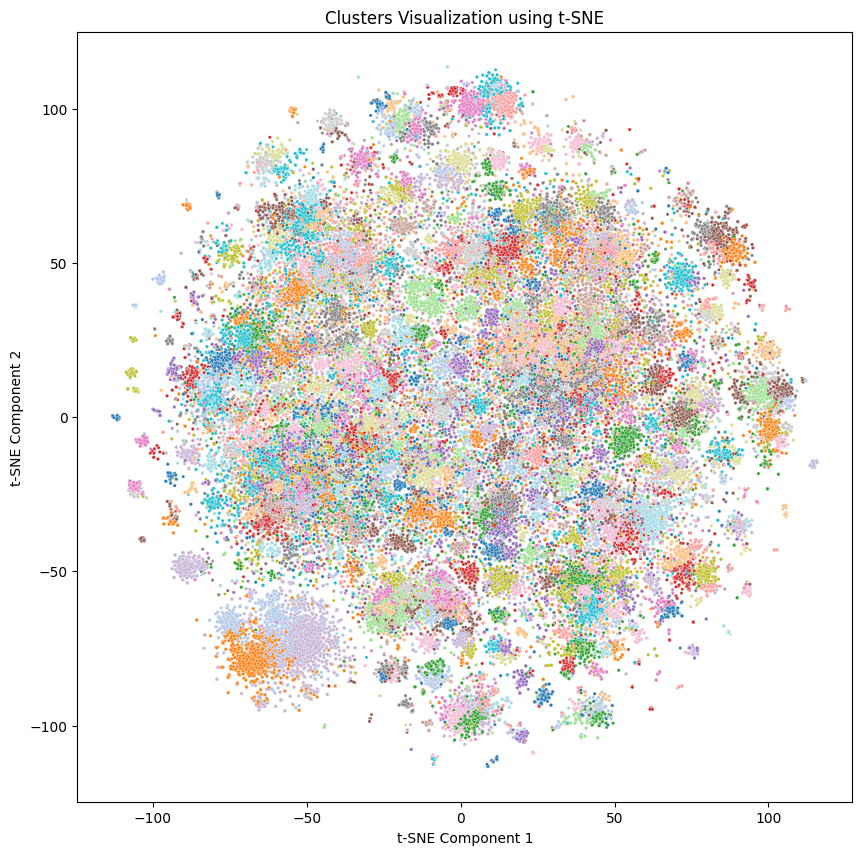

In [18]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_scaled)

cluster_df['TSNE1'] = embeddings_2d[:, 0]
cluster_df['TSNE2'] = embeddings_2d[:, 1]

# Plot clusters
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x='TSNE1', y='TSNE2', hue='cluster', palette='tab20', data=cluster_df, s=5, legend=False)

plt.title('Clusters Visualization using t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [16]:
value_count = cluster_df["cluster"].value_counts()
# filtered_values = value_count[(value_count > 30) & (value_count < 40)].index
# filtered_df = pi_cluster_df[pi_cluster_df["cluster"].isin(filtered_values)]
# print(filtered_df["cluster"].value_counts())
print(value_count)

cluster
442    1930
29     1869
778    1222
50      643
201     486
       ... 
898      10
963       9
663       9
990       8
647       5
Name: count, Length: 1000, dtype: int64
